In [68]:
import os
from utils import DataSeq, load_pickle_mv, load_ids

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.losses import Loss

from sklearn.utils import shuffle

import keras_tuner as kt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [69]:
pkl_path = "./mv.pkl"
images_path = "./Train_non_experts_simple/"
test_path = "./Test/"
batch_size = 8
epochs = 10

In [70]:
ids, labels = load_pickle_mv(pkl_path, images_path)
ids, labels = shuffle(ids, labels, random_state=42)
print(ids.shape, labels.shape)

test_ids, test_labels = load_ids(test_path)
test_ids, test_labels = shuffle(test_ids, test_labels, random_state=42)
print(test_ids.shape, test_labels.shape)


(75243,) (75243, 3)
(4364,) (4364, 3)


In [71]:
ids

array(['./Train_non_experts_simple/2/TCGA-EW-A1PH-DX1_xmin3455_ymin52049_A1PH_EW_x_ini_804_y_ini_3886.png',
       './Train_non_experts_simple/2/TCGA-AN-A0AT-DX1_xmin31171_ymin35756_A0AT_AN_x_ini_2144_y_ini_3350.png',
       './Train_non_experts_simple/2/TCGA-GM-A2DB-DX1_xmin50586_ymin43110_A2DB_GM_x_ini_8308_y_ini_5360.png',
       ...,
       './Train_non_experts_simple/2/TCGA-D8-A1XQ-DX1_xmin61261_ymin33317_A1XQ_D8_x_ini_1742_y_ini_3886.png',
       './Train_non_experts_simple/1/TCGA-OL-A5D6-DX1_xmin134495_ymin27944_A5D6_OL_x_ini_2010_y_ini_3752.png',
       './Train_non_experts_simple/1/TCGA-AR-A0TU-DX1_xmin88352_ymin23098_A0TU_AR_x_ini_2010_y_ini_536.png'],
      dtype='<U100')

In [72]:
# Loading images with generator

train_seq = DataSeq(ids, labels)
test_seq = DataSeq(test_ids, test_labels)

train_steps = len(ids) // batch_size
test_steps = len(test_ids) // batch_size

In [73]:
# X_train, X_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, random_state=42)

# train_seq = DataSeq(X_train, y_train)
# test_seq = DataSeq(X_valid, y_valid)

# train_steps = len(X_train) // batch_size
# test_steps = len(X_valid) // batch_size

# Hyperparameter Tuning

In [74]:
def build_model():
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)

    model = Model(input_layer, model, name="Transfer_VGG16")
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [76]:
model = build_model()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_seq, validation_data=test_seq, steps_per_epoch=train_steps,
    validation_steps=test_steps, epochs=10, callbacks=[stop_early])

Epoch 1/10
9405/9405 [==============================] - 476s 51ms/step - loss: 0.6046 - accuracy: 0.7682 - val_loss: 0.5406 - val_accuracy: 0.7856
Epoch 2/10
9405/9405 [==============================] - 475s 50ms/step - loss: 0.5160 - accuracy: 0.7873 - val_loss: 1.4883 - val_accuracy: 0.3287
Epoch 3/10
9405/9405 [==============================] - 477s 51ms/step - loss: 0.5053 - accuracy: 0.7946 - val_loss: 0.5507 - val_accuracy: 0.7968
Epoch 4/10
9405/9405 [==============================] - 475s 51ms/step - loss: 0.4974 - accuracy: 0.7974 - val_loss: 0.5358 - val_accuracy: 0.8009
Epoch 5/10
9405/9405 [==============================] - 476s 51ms/step - loss: 0.4894 - accuracy: 0.8000 - val_loss: 0.5064 - val_accuracy: 0.8149
Epoch 6/10
9405/9405 [==============================] - 473s 50ms/step - loss: 0.4849 - accuracy: 0.8015 - val_loss: 0.5214 - val_accuracy: 0.8156
Epoch 7/10
9405/9405 [==============================] - 475s 51ms/step - loss: 0.4830 - accuracy: 0.8035 - val_loss: 0

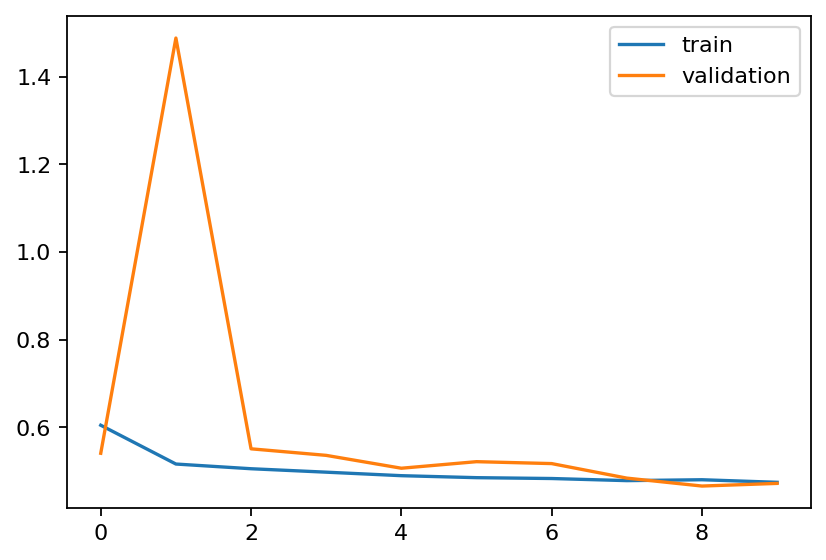

In [77]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [78]:
y_pred = model.predict(test_seq)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred))

546/546 [==============================] - 18s 33ms/step
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2692
           1       0.78      0.72      0.75      1196
           2       0.90      0.53      0.66       476

    accuracy                           0.83      4364
   macro avg       0.84      0.72      0.76      4364
weighted avg       0.83      0.83      0.82      4364



In [79]:
 model.save_weights('./bcss_aug_weights_mv_cce.h5')